# *Machine Learning Accelerates Identification of Priority Geological Images* 

**Executive Summary:**  
Two models were developed to aid and speed identification of distinguishing features and patterns in a set of geological imagery.  Using an unsupervised machine learning approach and, separately, a vector-distance/ similarity approach, the models successfully identified target images such that targets were most similar to a single input candidate image.  Both models yielded similar results, with some overlap in the returned target-image sets.  Both the K-Means unsupervised machine learning approach and the vector-distance/ similarity approach had similar elapsed times for prediction.  Fitting each model took less than a minute, with a training-set of approximately one-hundred thousand images.  However, elapsed time for training the K-Means model was significantly higher than the vector-distance/ similarity approach and may present limitations as the training data scales.   A/B testing with the customer is recommended to determine which model returns more valuable results.  Addition recommendations include discussion with the customer focussed on the necessity and feasibility to label features within the images to enable development of a supervised machine learning approach that may yield more relevant or diagnostic returns.

**Need:**  A geology research company needs a tool to aid and speed identification of interesting features and patterns in their imagery data. 

**Requirements:**
- Identify target images that are similar to a single candidate image.
- Score target images such that targets are most similar to the candidate image.
- Return n-target images based on defined input.

**Approach:**
- Because the images lacked wholesale labels or labels for specific features within the images, an unsupervised machine learning approach was appropriate.
- In addition to an unsupervised machine learning apparoch, the requirements could also be met via vector-distance/ similarity methods.  This approach was also tested.

**Methodology:**

*Setup*
>- Create root directory {choose_a_name}
>- Create sub-directory named *notebooks*
>- Create sub-directory named *datasets*
>- Create sub-directory named *images*
>- Within *images* directory, create sub-directory *dev*

*Extract, Transform, Load*
>- Unzip geological_similarity.zip in *images* directory using ETL Class unzip_images() method.
>- Randomly sample images for development and testing purposes using ETL Class sample_images() method.
>- Augment remaining training data by creating additional training examples via image rotation using ETL Class rotate_images() method.
>- Generate image metadata for all images using ETL Class generate_image_metadata() method.
>- Convert images to vectors for model training and store in m by n dimensional array using ETL Class images_to_vectors_df() method.

*Optimize K-Means Model*
>-  Optimize model hyperparameter to the training set by calculating estimator inertia for a range of cluster numbers using KMmeansModel Class model_inertias() method.
>- Visualize inertias using the Plots Class elbow_plot() method.
>- Set the optimal number of clusters as the default based on the Elbow plot.

*Fit K-Means Model*
>- Fit the K-Means model using the training data and the KMeansModel Class fit() method.

*Fit Vector-distance/ similarity Model*
>- Fit the vector-distance/ similarity model using the training data and the PairwiseModel Class fit() method.

*Load Candidate Image*
>- Load candidate image using the ETL Class read_image() method.
>- Visualize candidate image.
>- Vectorize candidate image for prediction using the ETL Class flatten_image() method.

*Predict Target Images with K-Means Model*
>- Identify similar target images to candiate image using the KMeansModel Class predict() method.
>- Visualize target images using the Plots Class plot_matches() method. 
 
*Predict Target Images with Vector-distance/ similarity Model*
>- Identify similar target images to candidate image using the PairwiseModel Class predict() method.
>- Visualize target images using the Plots Class plot_matches() method. 

**Source Code:**
- Source code below and available as an installable package at:  https://github.com/neumj/awsint
- Viewable report available at:  http://proodicals.com/geo_sim/geological_similarity.html

## Source Code and Execution Example

### Setup

In [1]:
import os
import imageio
import json
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import pairwise_distances
import pandas as pd
import random
import shutil
import math
from sklearn.cluster import KMeans
from zipfile import ZipFile
from scipy import ndimage
import time

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

###  ETL Class

In [3]:
class ETL():
    """
        Class for ETL of geological_similarity.zip image data.

    """
    def __init__(self, images_path='../images/geological_similarity',
                 data_path='../datasets', dev_path='../images/dev',
                 sub_dirs=['andesite','gneiss','marble','quartzite','rhyolite','schist']):
        """
           The constructor for etl class.

           Arguments:
            images_path -- string, path to root directory containing images.
            data_path -- string, path to save output to.
            dev_path -- string, path to dev directory.
            sub_dirs -- list, of directories holding images at root images directory.

           Returns:
            None.

           Tips:
            None.

        """
        self.images_path = images_path
        self.data_path = data_path
        self.dev_path = dev_path
        self.sub_dirs = sub_dirs


    def unzip_images(self, file_path):
        """
           Unzip .zip file.

           Arguments:
            file_path -- string, path to file.

           Returns:
            None.

           Tips:
            None.

        """
        with ZipFile(file_path, 'r') as zipObj:
            zipObj.extractall('../images')


    def sample_images(self, sample_percent=0.1):
        """
           Randomly sample and move images for training/ development purposes.

           Arguments:
            sample_percent -- float, percentage of images to sample.

           Returns:
            None.

           Tips:
            - Uses paths defined in class initiation.

        """
        for sd in self.sub_dirs:
            files = os.listdir(self.images_path + os.sep + sd)
            sample = random.sample(files, int(np.floor(len(files) * sample_percent)))
            for f in sample:
                source_file = self.images_path + os.sep + sd + os.sep + f
                dev_file = self.dev_path + os.sep + f
                shutil.move(source_file, dev_file)


    def rotate_images(self):
        """
           Rotate and output images in image root directory.

           Arguments:
            None.

           Returns:
            None.

           Tips:
            - Uses paths defined in class initiation.
            - Can be used to augment training data set.

        """
        rots = [90, 180, 270]
        for sd in self.sub_dirs:
            files = os.listdir(self.images_path + os.sep + sd)
            for f in files:
                source_file = self.images_path + os.sep + sd + os.sep + f
                im = self.read_image(source_file)
                for r in rots:
                    rot_file = self.images_path + os.sep + sd + os.sep \
                               + f.split('.')[0] + '_' + str(r) + '.' + f.split('.')[1]
                    im_rot = ndimage.rotate(im, r)
                    imageio.imwrite(rot_file, im_rot)


    def read_json(self, file_path):
        """
           Read and json file.

           Arguments:
            file_path -- string, path to file.

           Returns:
            d -- dictionary, with json contents.

           Tips:
            None.

        """
        with open(file_path) as json_data:
            d = json.load(json_data)

        return d


    def write_json(self, data_dict, file_path):
        """
           Write dictionary to json.

           Arguments:
            data_dict -- dictionary.
            file_path -- string, path to file.

           Returns:
            None.

           Tips:
            None.

        """
        with open(file_path, 'w') as fp:
            json.dump(data_dict, fp, indent=4)


    def generate_image_metadata(self, exp_size=(28, 28, 3)):
        """
           Generate metadata for images in root image directory.

           Arguments:
            exp_size -- tuple, expected image height, width, channels.

           Returns:
            images_meta_data -- dictionary, of image metadata.

           Tips:
            None.

        """
        self.images_meta_data = {'root': self.images_path,
                                 'dirs': [],
                                 'images': {},
                                 'errata': []}
        for (root, dirs, files) in os.walk(self.images_path, topdown=False):
            if len(files) > 1:
                for f in files:
                    im = imageio.imread(root + os.sep + f)
                    img_key = root.split(os.sep)[-1] + '.' + f.split('.')[0]
                    self.images_meta_data['images'].update({img_key: {'file_name': f, 'root': root,
                                                                      'file_path': root + os.sep + f,
                                                                      'size': im.shape}})
                    if im.shape != exp_size:
                        self.images_meta_data['errata'].append({'error': 'odd size', 'file_path': root + os.sep + f})
            else:
                self.images_meta_data['dirs'].append(dirs)

        return self.images_meta_data


    def read_image(self, file_path, to_grey_scale=0):
        """
           Read and image file.

           Arguments:
            file_path -- string, path to file.
            to_grey_scale -- scalar, 0 or 1.  Convert image to grey scale.

           Returns:
            im -- imageio.core.util.Array

           Tips:
            None.

        """
        im = imageio.imread(file_path)
        if to_grey_scale == 1:
            im = im.mean(axis=2)

        return im


    def flatten_image(self, image_array, normalize=1):
        """
           Flatten an image array.

           Arguments:
            image_array -- array, > 2-dimensional array.
            normalize -- scalar, 0 or 1.  Normalize by 255.

           Returns:
            flat -- array, 1-dimensional array.

           Tips:
            None.

        """
        flat = image_array.flatten()
        if normalize == 1:
            flat = flat / 255.

        return flat


    def images_to_vectors_df(self, image_size=[28 ,28 ,3], to_grey_scale=0):
        """
           From image metadata, read images, flatten, and load into an array for training.

           Arguments:
            image_size -- list, input image height, width, channels.
            to_grey_scale -- scalar, 0 or 1.  Convert image to grey scale.

           Returns:
            vectors_df -- Pandas dataframe, of image vectors for model training or other analysis.

           Tips:
            None.

        """
        df_idx = []
        if to_grey_scale == 0:
            im_array = np.zeros((len(self.images_meta_data['images']) ,(image_size[0] * image_size[1] * image_size[2])))
        elif to_grey_scale == 1:
            im_array = np.zeros((len(self.images_meta_data['images']) ,(image_size[0] * image_size[1] * 1)))

        im_count = 0
        for ky in self.images_meta_data['images'].keys():
            im = self.read_image(self.images_meta_data['images'][ky]['file_path'], to_grey_scale=to_grey_scale)
            im = self.flatten_image(im)
            im_array[im_count ,:] = im
            df_idx.append(ky)
            im_count += 1

        self.vectors_df = pd.DataFrame(data=im_array, index=df_idx)

        return self.vectors_df

### KMeansModel Class

In [4]:
class KMeansModel():
    """
        Class for K-Means based model.

    """
    def __init__(self):
        """
           The constructor for kmeans_model class.

           Arguments:
            None.

           Returns:
            None.

           Tips:
            None.

        """
        pass


    def fit(self, image_vectors_df, num_clusters=3):
        """
           Fit the K-Means model, creates an estimator and index of cluster labels.

           Arguments:
            image_vectors_df -- Pandas dataframe containing vector representations of training images.
            num_clusters -- scalar, number of clusters for K-Means.

           Returns:
            None.

           Tips:
            - Input image_vectors_df can be generated from images_to_vectors_df() method in etl module.
            - num_clusters default has been determined via inertial modeling.

        """
        self.reference_vectors = image_vectors_df
        self.estimator = KMeans(n_clusters=num_clusters, random_state=0).fit(self.reference_vectors)
        self.cluster_idx = self.estimator.labels_


    def predict(self, candidate_vector, k_candidates=12, dist_metric='correlation'):
        """
           Predict cluster membership for candidate_vector and calculate pairwise distances to same-cluster neighbors.

           Arguments:
            candidate_vector -- numpy array from flattened candidate image.
            k_candidates -- scalar, number of nearest neighbors to return.
            dist_metric -- string, any valid metric from scipy.spatial.distance.pdist.

           Returns:
            dist_df -- Pandas dataframe with K-nearest neighbors.

           Tips:
            - Input candidate_vector can be generated from read_image() and flatten_image() methods in etl module.
            - Default dist_metric value set based on small batch testing.

        """
        vector = candidate_vector.reshape((1, candidate_vector.shape[0]))
        self.prediction = self.estimator.predict(vector)
        ref_vectors_subset = self.reference_vectors[self.cluster_idx == self.prediction]
        distances = pairwise_distances(ref_vectors_subset.values, Y=vector, metric=dist_metric)
        dist_df = pd.DataFrame(data={dist_metric: distances[: ,0]}, index=ref_vectors_subset.index)
        dist_df.sort_values(by=[dist_metric], ascending=True, inplace=True)

        return dist_df[0:k_candidates]


    def model_inertias(self, clusters):
        """
           Generate estimator inertia for a set of cluster values to determine the optimal number of clusters
           based on the training data.

           Arguments:
            clusters -- list, of cluster values.

           Returns:
            inertias -- list, of estimator inertias.

           Tips:
            - clusters, inertias can be passed to elbow_plot() method in visualize module.

        """
        inertias = []
        for k in clusters:
            self.fit(self.reference_vectors, num_clusters=k)
            inertias.append(self.estimator.inertia_)

        return inertias

### PairwiseModel Class.

In [5]:
class PairwiseModel():
    """
        Class for Pairwise distance based model.

    """
    def __init__(self):
        """
            The constructor for distance_model class.

           Arguments:
            None.

           Returns:
            None.

           Tips:
            None.

        """
        pass


    def fit(self, image_vectors_df):
        """
           Seed data for Pairwise distance calculations.

           Arguments:
            image_vectors_df -- Pandas dataframe containing vector representations of training images.

           Returns:
            None.

           Tips:
            - Input image_vectors_df can be generated from images_to_vectors_df() method in etl module.

        """
        self.reference_vectors = image_vectors_df


    def predict(self, candidate_vector, k_candidates=12, dist_metric='correlation'):
        """
           Calculate pairwise distance from reference_vectors to candidate_vector.

           Arguments:
            candidate_vector -- numpy array from flattened candidate image.
            k_candidates -- scalar, number of nearest neighbors to return.
            dist_metric -- string, any valid metric from scipy.spatial.distance.pdist.

           Returns:
            dist_df -- Pandas dataframe with K-nearest neighbors.

           Tips:
            - Input candidate_vector can be generated from read_image() and flatten_image() methods in etl module.
            - Default dist_metric value set based on small batch testing.

        """
        vector = candidate_vector.reshape((1, candidate_vector.shape[0]))
        distances = pairwise_distances(self.reference_vectors.values, Y=vector, metric=dist_metric)
        dist_df = pd.DataFrame(data={dist_metric: distances[: ,0]}, index=self.reference_vectors.index)
        dist_df.sort_values(by=[dist_metric], ascending=True, inplace=True)

        return dist_df[0:k_candidates]

### Plots Class

In [6]:
class Plots():
    """
        Class for generating visualizations.

    """
    def __init__(self):
        """
           The constructor for kmeans_model class.

           Arguments:
            None.

           Returns:
            None.

           Tips:
            None.

        """
        pass


    def read_image(self, file_path, to_grey_scale=0):
        """
           Read and image file.

           Arguments:
            file_path -- string, path to file.
            to_grey_scale -- scalar, 0 or 1.  Convert image to grey scale.

           Returns:
            im -- imageio.core.util.Array

           Tips:
            None.

        """
        im = imageio.imread(file_path)
        if to_grey_scale == 1:
            im = im.mean(axis=2)

        return im


    def plot_matches(self, matches_df, meta_data):
        """
           Plot images returned from kmeans_model.predict or distance_model.predict.

           Arguments:
            matches_df -- Pandas dataframe, K-nearest matches from model.predict.
            meta_data -- dictionary, metadata for training images.

           Returns:
            None.

           Tips:
            - Input meta_data can be generated from generate_image_metadata() method in etl module.
            - Presupposes %matplotlib inline

        """
        match_paths = []
        for ky in matches_df.index:
            match_paths.append(meta_data['images'][ky]['file_path'])

        k = len(matches_df.index)
        nrows = math.ceil(k / 3)
        figsize=(15, 15)
        fig,a =  plt.subplots(nrows,3,figsize=(int(k * 1.5), int(k * 1.5)))
        fig.tight_layout(h_pad=2)
        im_count = 0
        for i in range(nrows):
            for j in range(3):
                disp = self.read_image(match_paths[im_count], to_grey_scale=0)
                a[i][j].imshow(disp)
                a[i][j].set_title(match_paths[im_count].split(os.sep)[-2] + ':' + match_paths[im_count].split(os.sep)[-1])
                im_count += 1
                if im_count == k:
                    break


    def elbow_plot(self, clusters, inertias):
        """
           Generate an Elbow Plot of estimator inertias to optimize K-Means cluster number.

           Arguments:
            clusters -- list, of cluster values.
            inertias -- list, of estimator inertias.

           Returns:
            None.

           Tips:
            - Inputs can be generated from model_inertias() method in cluster module.
            - Presupposes %matplotlib inline

        """
        plt.plot(clusters, inertias, 'ro-')
        plt.ylabel('Inertia')
        plt.xlabel('num_clusters')
        plt.title('K-Means Elbow Plot')

### Extract, Transform, Load

In [7]:
images_etl = ETL()
images_etl.unzip_images('../images/geological_similarity.zip')
images_etl.sample_images(sample_percent=0.01)
images_etl.rotate_images()

In [8]:
_ = images_etl.generate_image_metadata()
images_etl.write_json(images_etl.images_meta_data, '../datasets/images_meta_data.json')
img_vectors = images_etl.images_to_vectors_df()

In [10]:
print('Number of files: ' + str(len(images_etl.images_meta_data['images'].keys())))
print('Number of non 28x28x3 files: ' + str(len(images_etl.images_meta_data['errata'])))
print('Image vector size: ' + str(img_vectors.shape[1]))

Number of files: 118795
Number of non 28x28x3 files: 0
Image vector size: 2352


### Optimize K-Means Model

In [ ]:
model_kmeans_dev = KMeansModel()
model_kmeans_dev.fit(img_vectors)
inertias_dev = model_kmeans_dev.model_inertias([1,2,3,4,5,6,7,8,9,10])

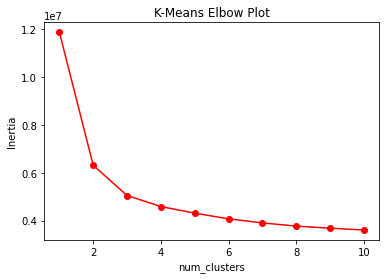

In [13]:
viz = Plots()
viz.elbow_plot([1,2,3,4,5,6,7,8,9,10],inertias_dev)

### Fit K-Means Model

In [36]:
tic = time.time()
model_kmeans = KMeansModel()
model_kmeans.fit(img_vectors)
toc = time.time()
print("Time to fit (s): " + str(toc - tic))

Time to fit (s): 44.53550481796265


### Fit Vector-distance/ similarity Model

In [37]:
tic = time.time()
dist_model = PairwiseModel()
dist_model.fit(img_vectors)
toc = time.time()
print("Time to fit (s): " + str(toc - tic))

Time to fit (s): 0.00010013580322265625


### Load Candidate Image

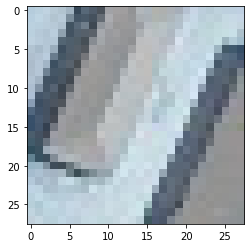

In [38]:
candidate_path = '../images/dev/C38Z2.jpg'
candidate_img = images_etl.read_image(candidate_path)
plt.imshow(candidate_img)
candidate_vect = images_etl.flatten_image(candidate_img)

### Predict Target Images with K-Means Model

In [39]:
tic = time.time()
matches_k = model_kmeans.predict(candidate_vect, k_candidates=9)
toc = time.time()
print("Time to predict (s): " + str(toc - tic))

Time to predict (s): 1.0489599704742432


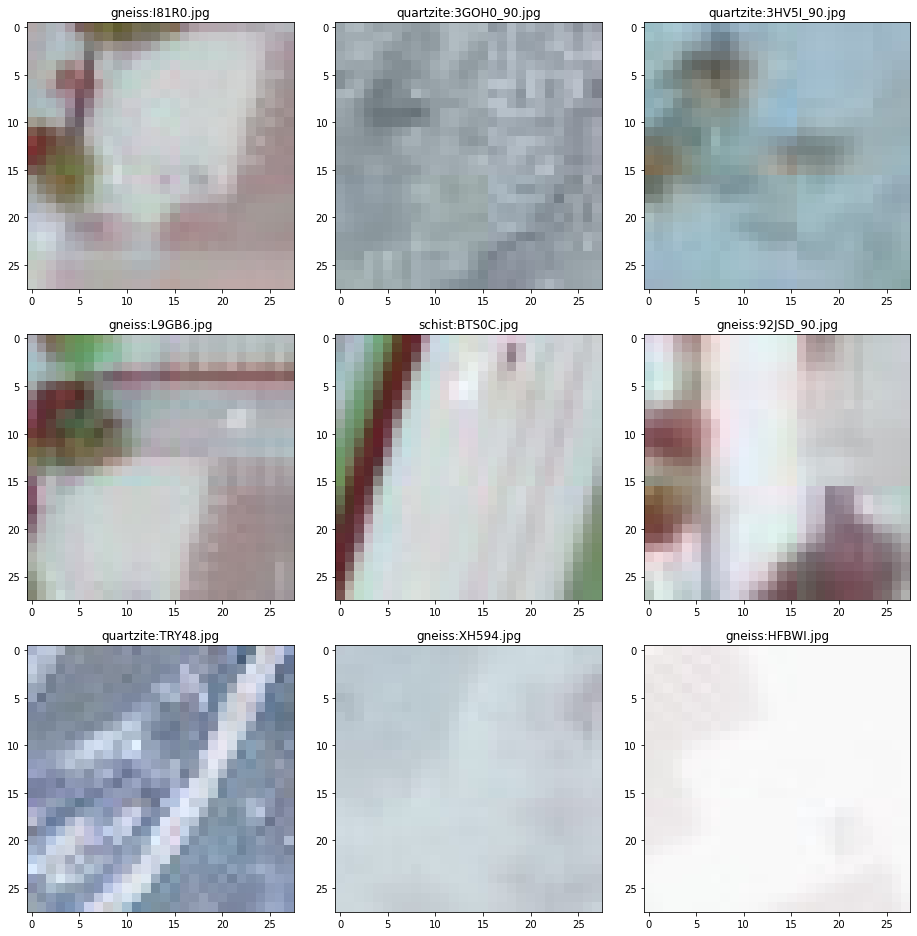

In [40]:
viz.plot_matches(matches_k, images_etl.images_meta_data)

### Predict Target Images with Vector-distance/ similarity Model

In [41]:
tic = time.time()
matches_d = dist_model.predict(candidate_vect, k_candidates=9)
toc = time.time()
print("Time to predict (s): " + str(toc - tic))

Time to predict (s): 2.6544830799102783


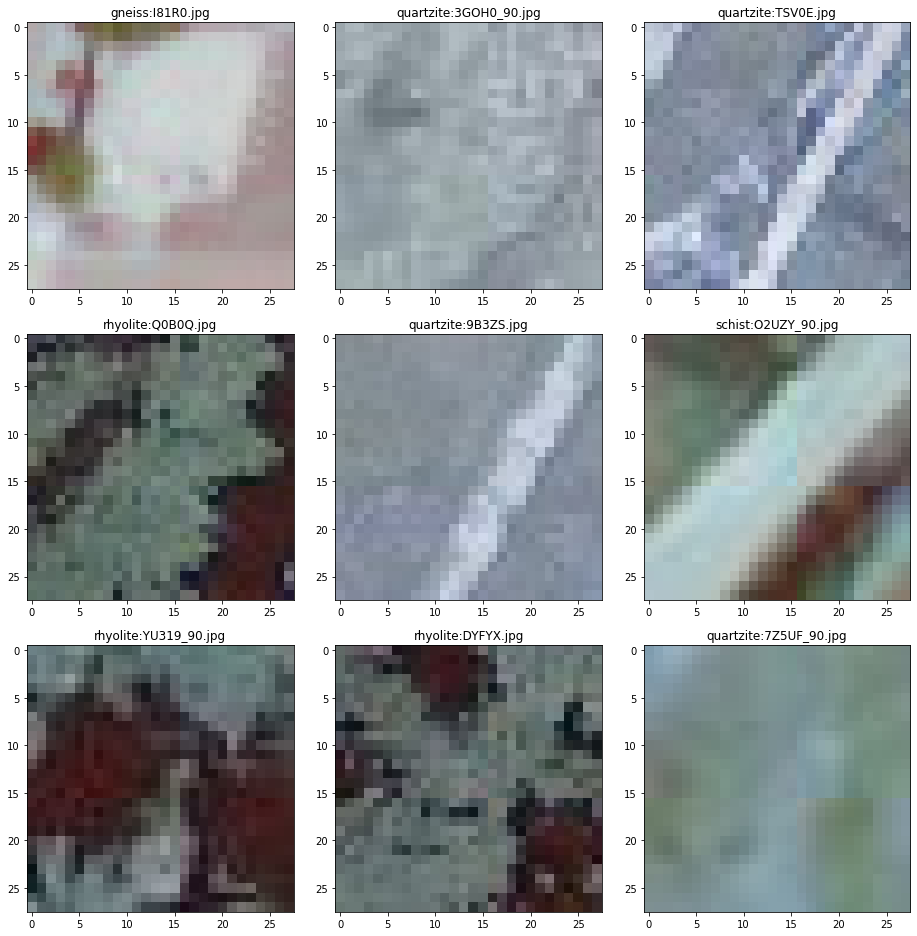

In [23]:
viz.plot_matches(matches_d, images_etl.images_meta_data)

In [ ]:
#mjn